# **Part 1 : Setting up Gymnasium**

To setting up gymnasium, I install the base Gymnasium library by using `conda install conda-forge::gymnasium` and try running a CartPole-v1 environment reference by https://github.com/Farama-Foundation/Gymnasium.

In [1]:
import gymnasium as gym
env = gym.make("CartPole-v1")

observation, info = env.reset(seed=42)
for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        observation, info = env.reset()
env.close()

# **Part 2 : Q-Learning on Blackjack**

To understand how to modify an agent to learn with different learning algorithms reference by https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/

In [2]:
from IPython.display import Image

Image(url='https://gymnasium.farama.org/_images/blackjack_AE_loop_dark.png', width = 800, height = 550)

## **Note** 
**In case I forget how to play Blackjack**

***Objective :*** To win, your card sum should be greater than the dealers without exceeding 21.

***Action Space :*** shape is (1,) in the range {0, 1} indicating whether to stand (0) or hit (1).

***Observation Space :*** consists of a 3-tuple containing the player’s current sum, the value of the dealer’s one showing card (1-10 where 1 is ace), and whether the player holds a usable ace (0 or 1).

***Starting State :*** initialised in the following range.
- Player current sum in range [4, 12]
- Dealer showing card value in range [2, 11]
- Usable Ace in range [0, 1]

***Rewards :*** 
- win game +1
- lose game -1
- draw game 0
- win game with natural blackjack +1.5 (if natural is True) +1 (if natural is False) `*** dont get it`

***Episode End :***
- The player hits and the sum of hand exceeds 21.
- The player sticks.

An ace will always be counted as usable (11) unless it busts the player.

## **Try following the example of Q-learning**

### **Imports and Environment Setup**

In [3]:
# Author: Till Zemann
# License: MIT License

from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym


# Let's start by creating the blackjack environment.
# Note: We are going to follow the rules from Sutton & Barto.
# Other versions of the game can be found below for you to experiment.

env = gym.make("Blackjack-v1", sab=True)

In [4]:
# Other possible environment configurations are:

env = gym.make('Blackjack-v1', natural=True, sab=False)
# Whether to give an additional reward for starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).

env = gym.make('Blackjack-v1', natural=False, sab=False)
# Whether to follow the exact rules outlined in the book by Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.

### **Observing the environment**

In [5]:
# reset the environment to get the first observation
done = False # ususlly set false
observation, info = env.reset()

# observation = (16, 9, False)
# (players current sum, Value of the dealers face-up card, Boolean whether the player holds a usable ace (An ace is usable if it counts as 11 without busting))

### **Executing an action**

`next_state` : This is the observation that the agent will receive after taking the action.

`reward` : This is the reward that the agent will receive after taking the action.

`terminated` : This is a boolean variable that indicates whether or not the environment has terminated.

`truncated` : This is a boolean variable that also indicates whether the episode ended by early truncation, i.e., a time limit is reached.  `dont get`

`info` : This is a dictionary that might contain additional information about the environment. `** dont get`

In [6]:
# sample a random action from all valid actions
action = env.action_space.sample()
# action=1

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

# observation=(24, 10, False)
# reward=-1.0
# terminated=True
# truncated=False
# info={}

`terminated = True` or `truncated = True`, we should stop the current episode and begin a new one with `env.reset()`.

### **Building an agent**

In [7]:
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        
        """
        Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
            
        """
        
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        
        """
        
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        
        """
        Updates the Q-value of an action.
        
        """
        
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (reward + self.discount_factor * future_q_value - self.q_values[obs][action])

        self.q_values[obs][action] = (self.q_values[obs][action] + self.lr * temporal_difference)
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [8]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [9]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
q_learning_win_count = 0
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    
    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(obs, action, reward, terminated, next_obs)

        done = terminated or truncated
        obs = next_obs
   
    agent.decay_epsilon()
    
    if reward == 1:
        q_learning_win_count += 1

q_learning_win_rate = (q_learning_win_count / n_episodes) * 100

100%|██████████| 100000/100000 [00:15<00:00, 6435.32it/s]


### **Visualizing the training**

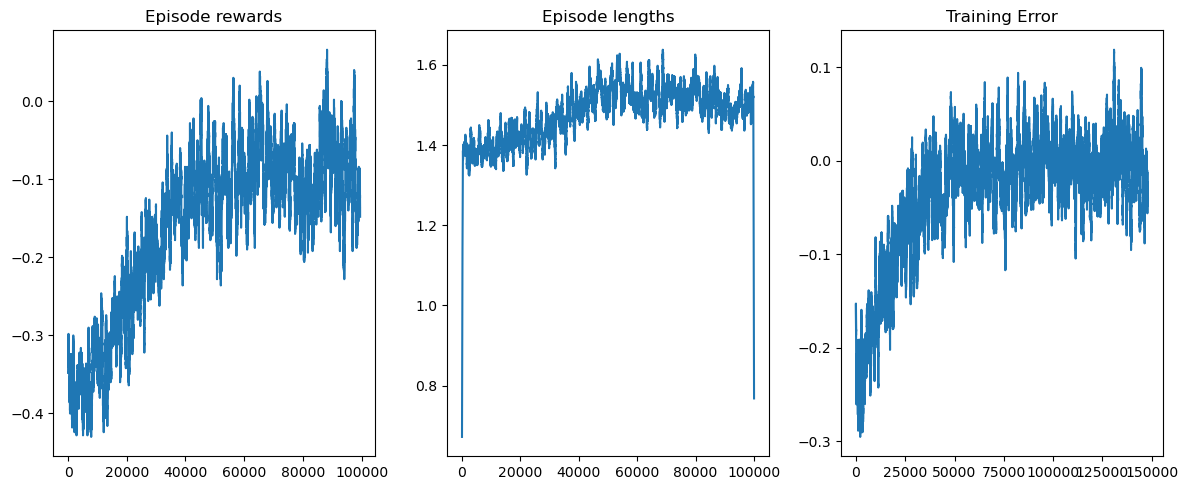

In [10]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

### **Visualising the policy**

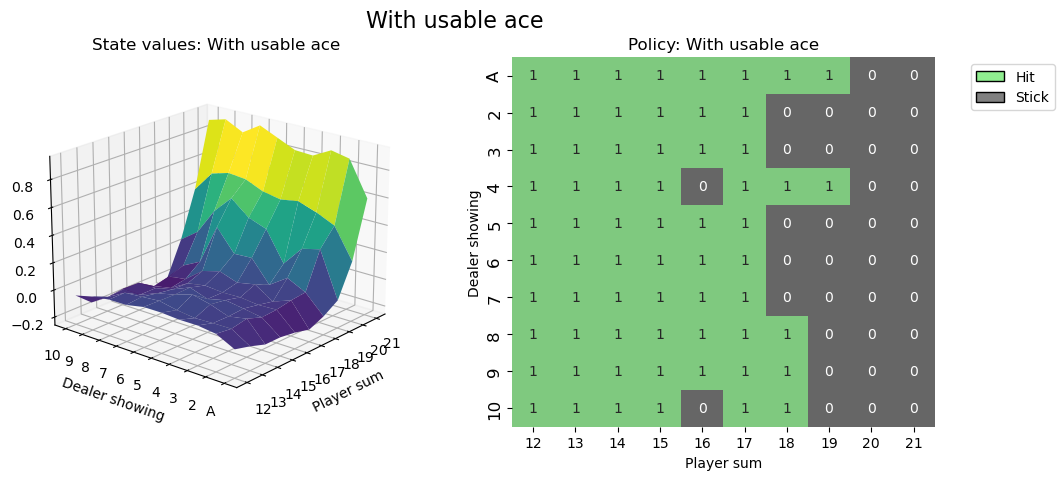

In [11]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

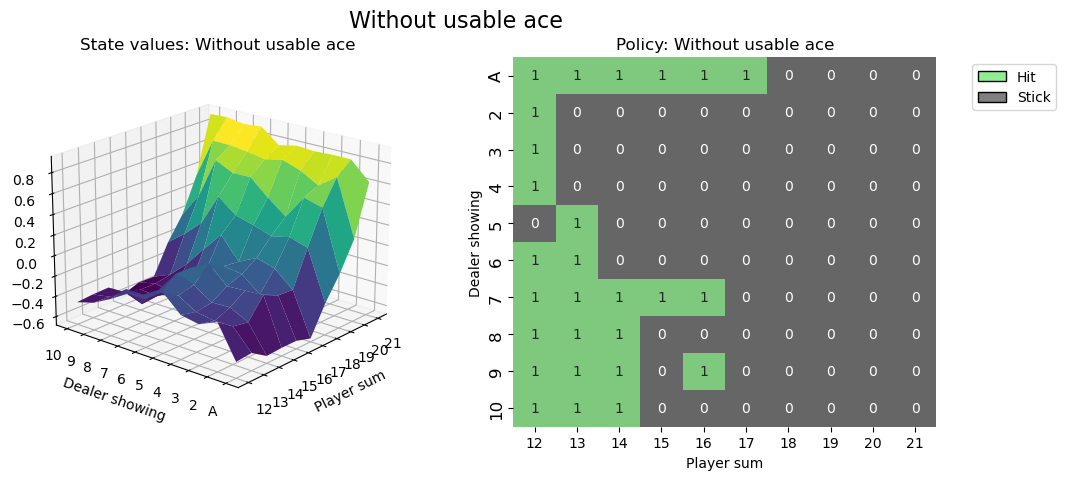

In [12]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

# **Part 3 : Exploring various learning algorithms**

## **Implement Monte Carlo Control**

The Monte Carlo method is used in reinforcement learning. This is because it is especially appropriate for the problem of how agents interact with their environment in each episode. and learning signals (such as rewards) are only available at the end of each episode.

keys : 

- The Monte Carlo method is randomized initially and only after that is the Q value function updated.
- The Monte Carlo method is always updated after a running episode ends.

In [13]:
''' import necessary library '''

import numpy as np
import seaborn as sns
from tqdm import tqdm
import gymnasium as gym
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [14]:
''' reward for starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21). '''

env = gym.make('Blackjack-v1', natural=True, sab=False)

In [15]:
''' done is a variable to check if a game is terminated '''

done = False 
observation, info = env.reset()
observation

(15, 7, 0)

In [16]:
''' action have 2 states, hit and stick '''

action = env.action_space.sample()
observation, reward, terminated, truncated, info = env.step(action)

print(observation, reward, terminated, truncated, info)

(15, 7, 0) 1.0 True False {}


In [17]:
''' Agent '''

class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):

        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    ''' I have changed the code in this section (update function) '''
 
    def update(self, episode):
        states, actions, rewards = zip(*episode)
        returns = 0
        for t in reversed(range(len(states))):
            state = states[t]
            action = actions[t]
            returns = self.discount_factor * returns + rewards[t]
            temporal_difference = (returns - self.q_values[state][action])
            self.q_values[state][action] += self.lr * temporal_difference
            self.training_error.append(temporal_difference)

    ''' ---------------------------------------------------------- '''

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In monte carlo control we only have single dictionary to store our Q values. By the concept of reinforcement learning, we need to learn the best policy to maximize returns. To achieve this, we initialize a dictionary q_values with default values of arrays of zeros. This ensures that the Q value is initialized uniformly across all states and actions before the learning process begins.

```python
self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
```

Instead, it simply obtains the average return of a State/Action pair over time, We use the update function to continually refine our policies. The update function is represented by the equation :

$$Q(s, a) ← Q(s, a) + α(G - Q(s, a))$$

This update function continuously improves our policy over time by adjusting the Q value based on observed returns and current estimates of the Q value.

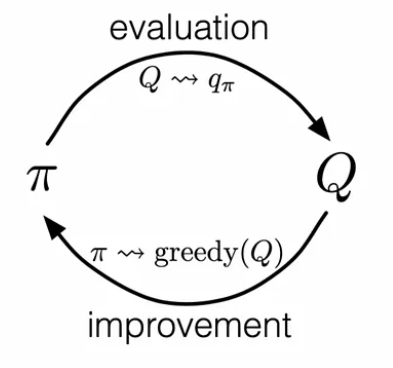

https://medium.com/@aminakeldibek/monte-carlo-control-6e3b70f173a8

In [18]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [19]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
mc_win_count = 0
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    
    ''' I have been changed the code on this part (update function) '''
    
    states = []
    actions = []
    rewards = []
    episode_transition = []

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        obs = next_obs
            
        states.append(obs)
        actions.append(action)
        rewards.append(reward) 
    
    episode_transition = list(zip(states, actions, rewards))
    agent.update(episode_transition)
    
    agent.decay_epsilon()
    
    if reward == 1:
        mc_win_count += 1
        
mc_win_rate = (mc_win_count / n_episodes) * 100

100%|██████████| 100000/100000 [00:17<00:00, 5622.58it/s]


In monte carlo, we update our agent's policies based on changes we notice in each episode. We loop the episodes followed by the number of episodes `(n_episodes)`. Each episode starts with resetting the environment to its default state and receives some basic observations (obs) and additional information (info). We create some of arrays to store the values of states, actions, rewards and zip in episode_transition.

Within each episode, the agent chooses actions based on its current policy `(agent.get_action(obs))` and interacts with the environment by receiving observations, rewards, and other information through `env.step(action)`.

After completing the episode, the collected episode transitions are packaged as a list of tuples `(episode_transition)`. This list is then passed to the agent's update function, which updates the agent's policy based on the observed transitions. Which means value function estimation and policy improvement are performed **only at the end of each episode**.


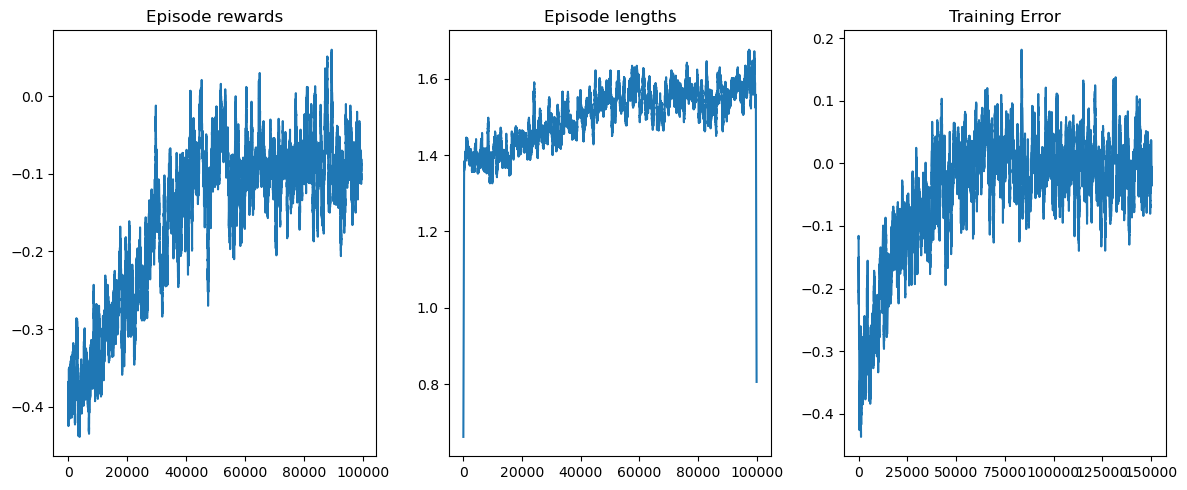

In [20]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
if rolling_length > 0:
    reward_moving_average = (
        np.convolve(
            np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
        )
        / rolling_length
    )
    axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
if rolling_length > 0:
    length_moving_average = (
        np.convolve(
            np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
        )
        / rolling_length
    )
    axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
if rolling_length > 0 and len(agent.training_error) > 0:
    training_error_moving_average = (
        np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
        / rolling_length
    )
    axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()



This can be slow because the agent has no way of learning from intermediate steps and has to wait until the entire game is played to learn how good a particular action was at a particular state.
The advantage of MC methods are that the estimates are unbiased due to actually finding the reward before updating the Q value.

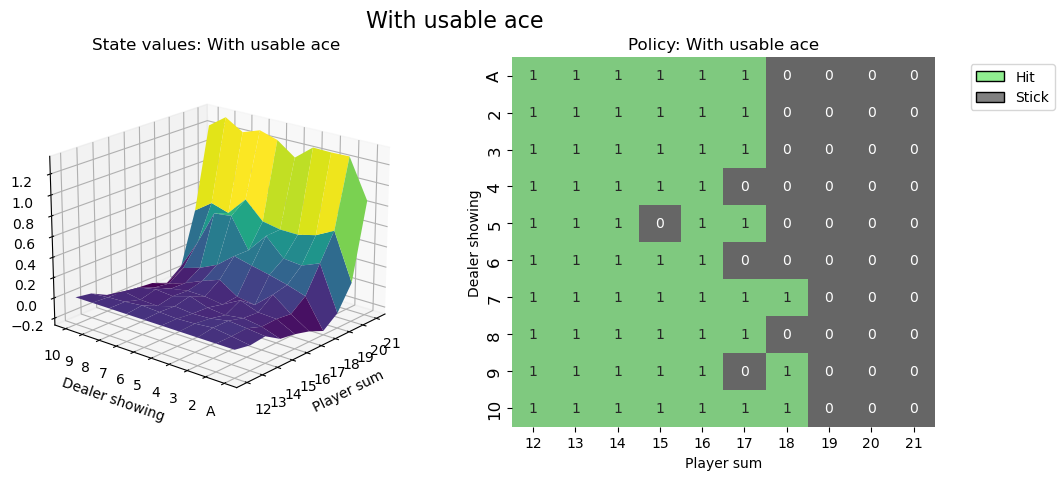

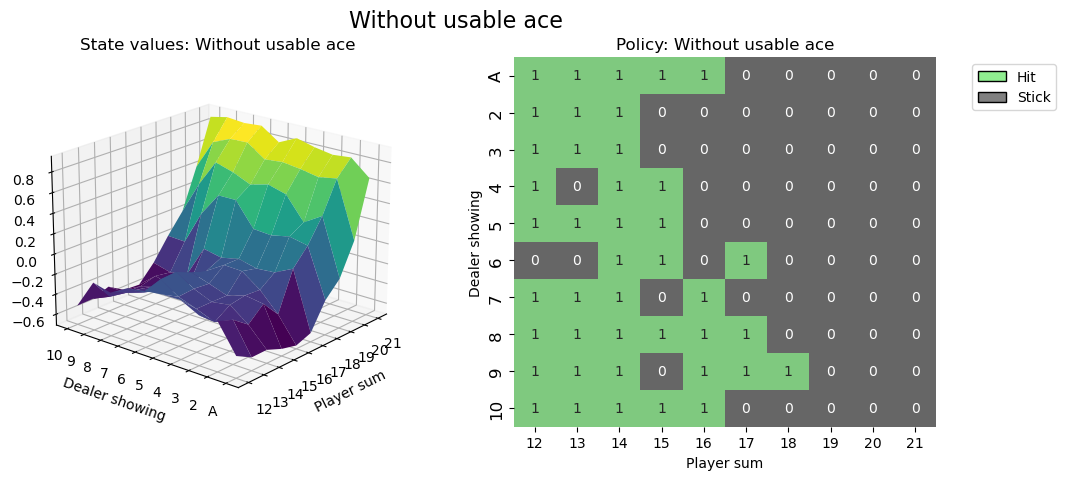

In [21]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

## **Implementing Temporal Difference Control**

Temporal-Difference (TD) Learning is a combination of : 
- Monte Carlo methods (can learn from experience without knowing the model) 
- Dynamic programming (update estimate based on other learned estimates)

The Temporal-Difference (TD) method for the estimation or prediction part. Just like in MC, we have a trade-off between exploration and exploitation. Here we present a policy-based TD control method.

In [22]:
''' import necessary library '''

import numpy as np
import seaborn as sns
from tqdm import tqdm
import gymnasium as gym
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [23]:
''' reward for starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21). '''

env = gym.make('Blackjack-v1', natural=True, sab=False)

''' I have been changed the code on this part (update function) '''
env.observation_space.seed(10)
np.random.seed(10)

''' ----------------------------------------------------------- '''

' ----------------------------------------------------------- '

The seed() function is used to initialize a random number generator with a specific seed value. This ensures the repeatability of the random process. When seed() is called with a specific value, it sets The seed of the random number generator is that value. Therefore, the subsequent random numbers generated will follow the given sequence.

In [24]:
''' done is a variable to check if a game is terminated '''

done = False 
observation, info = env.reset()
observation

(13, 10, 0)

In [25]:
''' action have 2 states, hit and stick '''

action = env.action_space.sample()
observation, reward, terminated, truncated, info = env.step(action)

# if terminated == True or truncated == True:
#     observation, info = env.reset()
# else:
#     pass

print(observation, reward, terminated, truncated, info)

(23, 10, 0) -1.0 True False {}


In [26]:
''' Agent '''

class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):

        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    ''' I have been changed the code on this part (update function) '''

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
        next_action: int,
    ):

        future_q_value = (not terminated) * (self.q_values[next_obs][next_action])
        temporal_difference = (reward + self.discount_factor * future_q_value - self.q_values[obs][action])

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)
         
    ''' ----------------------------------------------------------- '''
                
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

### **Sarsa : On-policy TD Control**
We use the TD method for the estimation or prediction part. Just like in MC, we have a trade-off between.we learn the action value function. Instead of a flag function For the policy method We must estimate q π ( s , a ) for the current behavioral policy π for all s and all a .

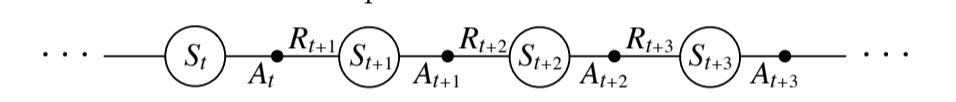

SARSA is classified as TD and is in policy. The TD method is to find the difference of the value function at the next state [Q(S', A')] and the current state [Q(S, A)], but the point that makes SARSA Unlike the Q-Learning calculation method, Q-Learning searches for the greatest value at the next state [max(Q(S', :))], but for SARSA, Policy selects the next action ( A') and so we find the value function[Q (S', A')] to use as a number and delete the original value function[Q(S, A)]. This is the algorithm we will use.
### On-policy control algorithm

We continually estimate `qπ` for the behavior policy `π` and at the same time change `π` towards greediness with respect to `qπ`
1. Initialize Q(s, a) arbitrarily, for all s in the state space and a in the action space.
2. Repeat (for each episode):
   - Initialize the starting state `s`.
   - Choose `a` from `s` using policy derived from `Q` (e.g., ϵ-greedy).
   - Repeat (for each step of the episode):
     - Take action `a`, observe reward `r` and next state `s'`.
     - Choose action `a'` from `s'` using policy derived from `Q` (e.g., ϵ-greedy).
     - Update `Q(s, a)` using the update rule:
        $$Q(s, a) <- Q(s, a) + α [r + γ Q(s', a') - Q(s, a)]$$

     - `s <- s'`, `a <- a'`.
   - Until `s` is terminal.


In [27]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [28]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
td_win_count = 0
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    
    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
                        
        ''' Choose A' from S' using policy derived from Q '''
        
        next_action = agent.get_action(next_obs)

        agent.update(obs, action, reward, terminated, next_obs, next_action)

        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()
    
    if reward == 1:
        td_win_count += 1
            
td_win_rate = (td_win_count / n_episodes) * 100

100%|██████████| 100000/100000 [00:17<00:00, 5654.50it/s]


Using `A_{t+1}` in the Sarsa equation is part of updating the Q-value that makes Sarsa an on-policy learning algorithm. This means it uses the current policy to learn and predict the Q-value of the next action directly while in the current state `S_t`.

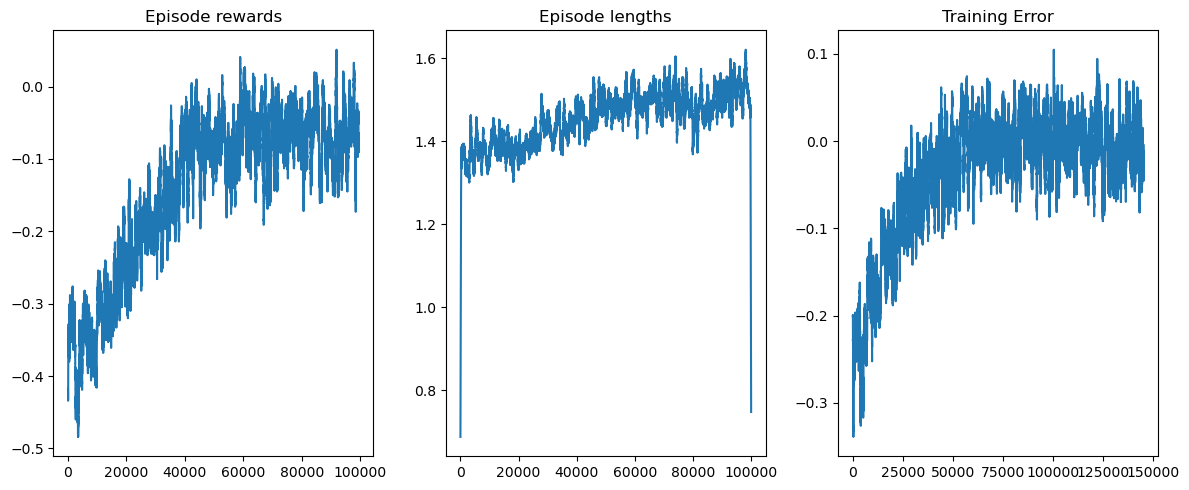

In [29]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
if rolling_length > 0:
    reward_moving_average = (
        np.convolve(
            np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
        )
        / rolling_length
    )
    axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
if rolling_length > 0:
    length_moving_average = (
        np.convolve(
            np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
        )
        / rolling_length
    )
    axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
if rolling_length > 0 and len(agent.training_error) > 0:
    training_error_moving_average = (
        np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
        / rolling_length
    )
    axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()


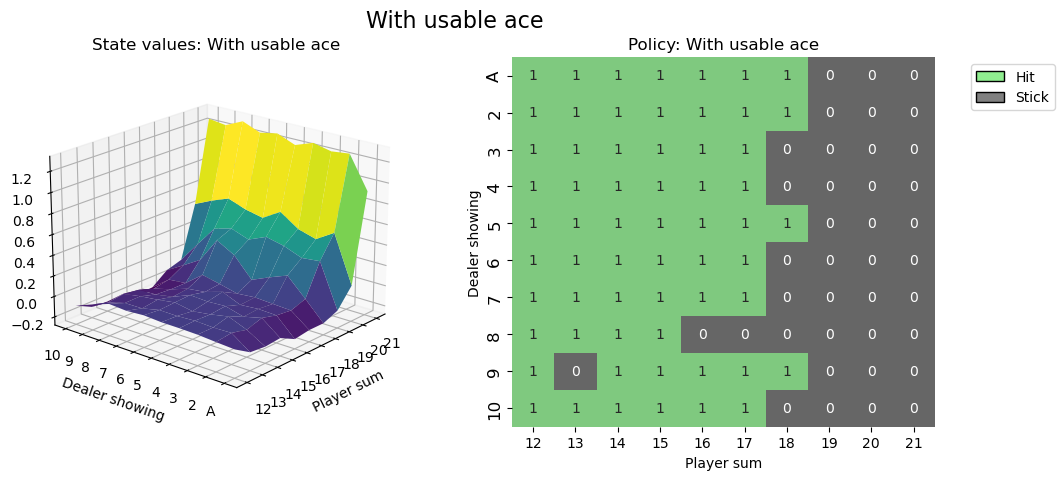

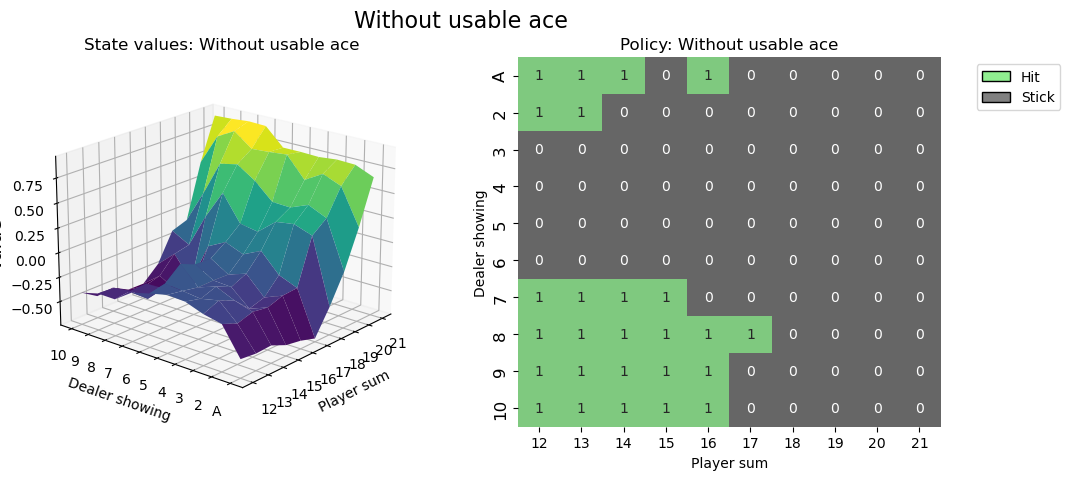

In [30]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

## **Implementing Double Q-Learning Control**

Double Q-learning introduces the idea of using two separate sets of Q values to estimate an action. This is achieved by maintaining two sets of Q values, often referred to as Q1 and Q2.

keys : 

- use two set of Q-values to select the action with the maximum Q-value.
- when an action is selected, the associated Q-value is updated using the Q-value from another set of Q-values.

Double Q-learningeffectively reduces the overestimation bias. and improve the strength of the learning process. And can lead to more stable and accurate policy learning. This is especially true in environments with high variance or random returns.

In [31]:
''' import necessary library '''

import numpy as np
import seaborn as sns
from tqdm import tqdm
import gymnasium as gym
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [32]:
''' reward for starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21). '''

env = gym.make('Blackjack-v1', natural=True, sab=False)

In [33]:
''' done is a variable to check if a game is terminated '''

done = False 
observation, info = env.reset()
observation

(20, 10, 0)

In [34]:
''' action have 2 states, hit and stick '''

action = env.action_space.sample()
observation, reward, terminated, truncated, info = env.step(action)

print(observation, reward, terminated, truncated, info)

(20, 10, 0) 1.0 True False {}


In [35]:
''' Agent '''

class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        self.q1_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.q2_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q1_values[obs] + self.q2_values[obs]))
    
    
    ''' I have been changed the code on this part (update function) '''
    
    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        if np.random.choice([True, False]):
            q1_values = self.q1_values
            q2_values = self.q2_values
        else:
            q1_values = self.q2_values
            q2_values = self.q1_values

        future_q_value = (not terminated) * np.max(self.q1_values[next_obs])
        temporal_difference = (reward + self.discount_factor * future_q_value - q1_values[obs][action])

        q1_values[obs][action] = (q1_values[obs][action] + self.lr * temporal_difference)

        self.training_error.append(temporal_difference)

    ''' ----------------------------------------------------------- '''
    
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In Double Q-learning, we update our agent's policy is updated based on two sets of Q-values, namely `q1_values` and `q2_values`. Initially, one of these sets is randomly selected using 

```python
np.random.choice([True, False])
```

to ensuring equal utilization of both sets during learning. This random selection reduces the overestimation bias inherent in traditional Q-learning algorithms. Then, the future Q-value for the next state `(next_obs)` is calculated if the episode has not yet ended. `(future_q_value)` are obtained from `q1_values` or `q2_values`, depending on the previously selected set.

The Q-values for the current state and actions `(obs, actions)` are updated using the temporal difference error and learning rate (`self.lr`) as equaton :

$$Q1(s, a) ← Q1(s, a) + α(G - γQ2(s, argmaxQ1(s, a)) - Q1(s, a))$$

This process is intended **to reduce the risk of overestimating operations Leads to more stable and accurate policy learning.**

In [36]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [37]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
double_q_learning_win_count = 0
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
               
        agent.update(obs, action, reward, terminated, next_obs)

        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()
    
    if reward == 1:
        double_q_learning_win_count += 1
        
double_q_learning_win_rate = (double_q_learning_win_count / n_episodes) * 100

100%|██████████| 100000/100000 [00:19<00:00, 5068.05it/s]


In Double Q-Learning, we update our agent's policies by interacts with the environment over multiple episodes, collects experience, and updates its policy based on observed transitions. Each episode starts with resetting the environment to its default state and receives some basic observations (obs) and additional information (info). 

Within each episode, the agent interacts with the environment by choosing actions based on its current policy (`agent.get_action(obs)`) and receiving observations, rewards, and other information through `env.step(action)`. The agent's action for the next step (`next_action`) is also determined.

After each step in the episode, the agent's `update` function is called with the current observation (`obs`), action taken (`action`), reward received, whether the episode has terminated (`terminated`), the next observation (`next_obs`), and the next action (`next_action`). This function is responsible for updating the agent's policy based on the observed transitions.

The loop continues until either the episode is terminated (`done`) or truncated (`truncated`). If the episode is terminated or truncated, the loop will exit the episode.

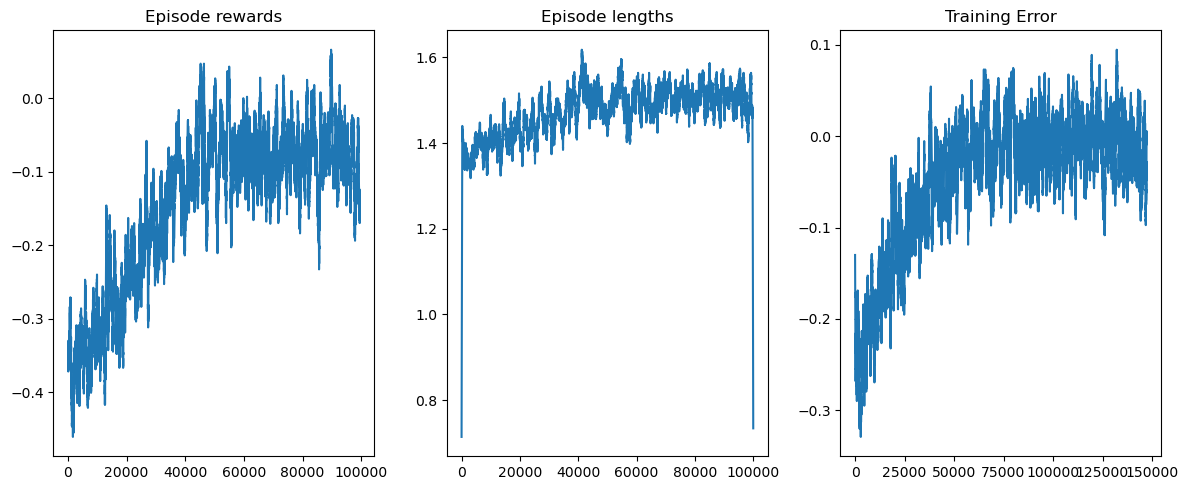

In [38]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
if rolling_length > 0:
    reward_moving_average = (
        np.convolve(
            np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
        )
        / rolling_length
    )
    axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
if rolling_length > 0:
    length_moving_average = (
        np.convolve(
            np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
        )
        / rolling_length
    )
    axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
if rolling_length > 0 and len(agent.training_error) > 0:
    training_error_moving_average = (
        np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
        / rolling_length
    )
    axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

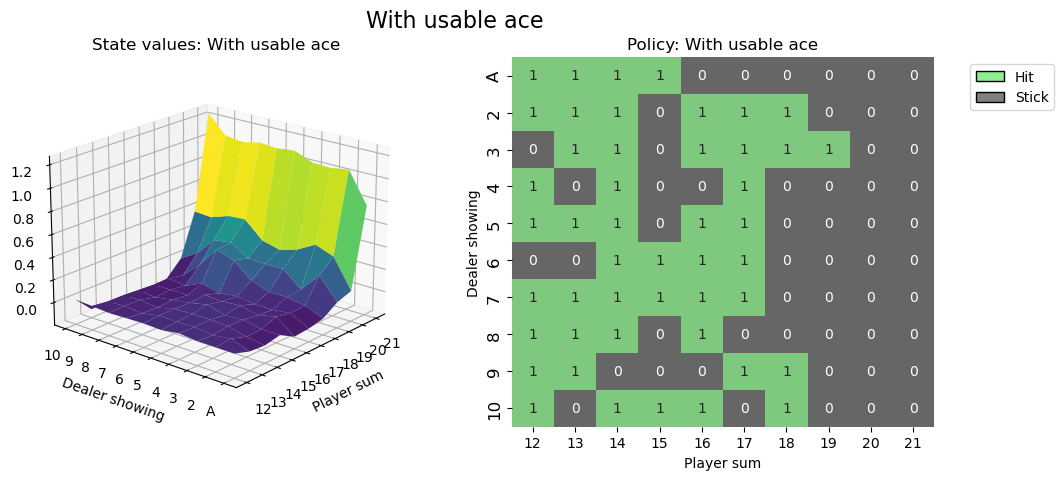

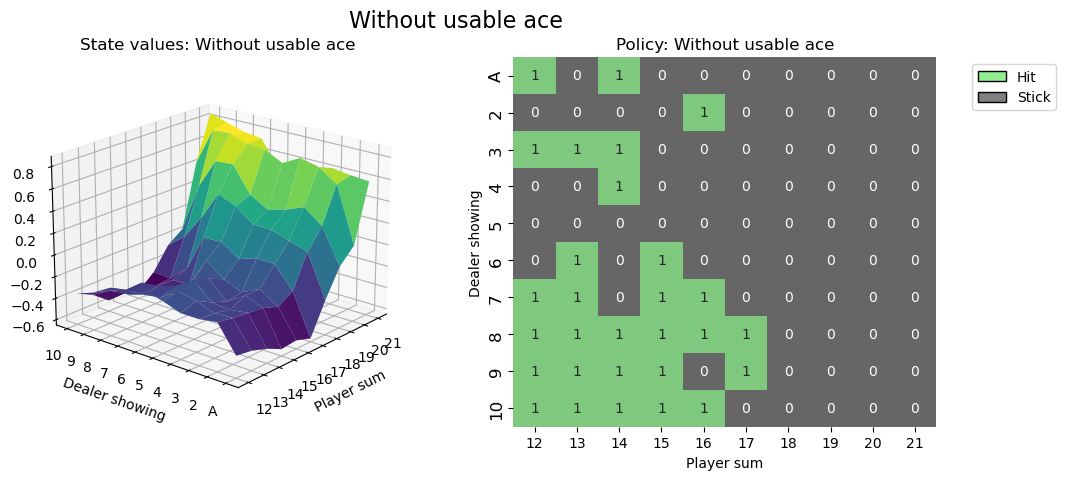

In [39]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # Convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)

    # Check if using q1_values or q2_values
    if np.random.choice([True, False]):
        q_values = agent.q1_values
    else:
        q_values = agent.q2_values

    for obs, action_values in q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # Players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # Create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # Create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid

def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()


## **Summarize and Analyze the result**

https://cmudeeprl.github.io/403_website/assets/lectures/s21/s21_rec5_DP&MC&TD.pdf

### **Monte Carlo**

Monte Carlo methods provide unbiased estimates of state values ​​or action values. This means that these values can converge to the true value without overestimating or underestimating it.

It is less sensitive to the initial values ​​of the state or action values because monte carlo method update values based on complete episode, which mean they will have enough value to estimates. They are tend to reliably converge to the optimal policies by directly estimate values ​​from observed returns and iteratively improves the estimate with each episode.

Limitations of Monte Carlo methods :

-  Need to complete each episode to earn rewards and update their value estimates. This means that values cannot be updated during an ongoing episode and you have to wait until the episode terminate.
- Cannot be used in continuous environment must terminate first.
- Affected by high variance especially in environments with stochastic rewards or long episode lengths.

### **TD control**

Temporal Difference methods are another class of reinforcement learning algorithms that offer several advantages over Monte Carlo methods. If compare to monte carlo their lower variance because they update value estimates based on single transitions rather than entire episode returns, resulting in more stable and less noisy updates. They also have ability to learn from incomplete episodes or partial sequences of interactions with the environment. 

Moreover, the TD method is more computationally efficient. This is especially true in environments with long episode lengths. Because it updates values based on a single transition, the TD method requires less memory and computational resources compared to the Monte Carlo method.

Limitations of Temporal Difference methods :

- High bias in value estimates because bootstrapping by using the estimate of the next state value. This bias can affect the accuracy of value estimates, particularly in the early stages of learning.
- Not suitable for every type of environments. They may struggle in episodic tasks with long episode lengths or highly variable rewards.


### **Q-Learning**

Q-learning learns directly from interactions with the environment without needing knowledge of the environment's model. It is an off-policy algorithm, meaning it learns the optimal policy while following a different policy. 

Q-learning updates Q-values based on a simple update rule derived from the Bellman equation, making it computationally efficient and easy to implement. It can update Q-values online after each time step, enabling real-time decision-making and adaptation to changes in the environment.

Furthermore, Q-learning can efficiently handle large state spaces by using function approximation techniques. This scalability allows Q-learning to tackle complex tasks with high-dimensional state spaces.

Limitations of Q-learning :

- Curse of dimensionality can occur when applied to tasks with large or continuous state spaces. Updating Q-values for every state-action pair can become memory-intensive, making it challenging to scale Q-learning to high-dimensional problems.
- Need a large number of samples or interactions with the environment to converge to an optimal policy, especially in environments with few rewards or complex dynamics.
- Assumes that the environment is stationary, meaning transition probabilities and returns do not change over time.
- Sensitive to estimating bias (especially in the early stages of learning or in environments with noisy rewards). This can lead to poor policy or slow convergence but can deal by using function approximation methods such as neural networks.

### **Double Q-Learning**

Double Q-learning addresses the issue of overestimation bias present in traditional Q-learning algorithms, which can lead to suboptimal policies. They use two sets of Q-values to estimate the value of actions and updates them alternately. It helps in reducing the overestimation of Q-values, leading to more accurate value estimates and better policy convergence. This can result in more robust learning and faster convergence to optimal policies, especially in environments with noisy rewards or complex dynamics.

They can be combined with function approximation techniques, such as neural networks, to handle large state spaces efficiently. By reducing overestimation bias, Double Q-learning helps stabilize learning with function approximation, leading to more reliable and accurate value estimates.

Limitations of Double Q-learning :

- Need to maintain two sets of Q values and switch between them during updates. This require the more memory compared to traditional Q-learning, especially in large state spaces.
- Two sets of Q-values and the alternating updates can lead to overfitting to the noise in the data, particularly in environments with few rewards or noisy observations.
- Limited exploration opportunities because it relies on alternating between two sets of Q-values, it may not explore all state-action pairs adequately, leading to suboptimal policies or slow convergence.
- In non-stationary environments, where the dynamics evolve or change over time, Double Q-learning may struggle to adapt and may require additional techniques to address concept drift or changing dynamics.

### **Differences between these 4 methods**

1. **Monte Carlo Control (MC)** :
   - In MC control, rewards are used to compute the return, which is the cumulative sum of rewards obtained from the current time step until the end of the episode.
   - MC control updates the value estimates (such as state values or action values) based on the observed returns at the end of each episode.
   - The return is typically used as the target for updating value estimates, and the update is performed after the completion of each episode.

2. **Temporal Difference (TD) Control** :
   - In TD control, rewards are used to compute temporal differences, which are the differences between the estimated value of the current state and the estimated value of the next state.
   - TD control updates the value estimates based on the observed rewards and the estimates of the next state values.
   - The temporal difference is used as the target for updating value estimates, and the update is performed after each time step, allowing for online learning.

3. **Q-learning** :
   - In Q-learning, rewards are used to compute the temporal difference error, which is the difference between the estimated Q-value of the current state-action pair and the estimated maximum Q-value of the next state.
   - Q-learning updates the Q-values based on the observed rewards and the estimated maximum Q-value of the next state.
   - The temporal difference error is used as the target for updating Q-values, and the update is performed after each time step, allowing for online learning.

4. **Double Q-learning** :
   - In Double Q-learning, rewards are also used to compute the temporal difference error, similar to Q-learning.
   - However, Double Q-learning uses two sets of Q-values to estimate the value of actions and alternates between them during updates, reducing the potential for overestimation bias.
   - The temporal difference error is used as the target for updating one set of Q-values, while the other set is used to select the action.
   - The update is performed after each time step, allowing for online learning, similar to Q-learning.

### **What algorithm performs best? Why?**

In [40]:
print("Win rate of MC :", mc_win_rate , "%")
print("Win rate of TD:", td_win_rate, "%")
print("Win rate of Q-Learning :", q_learning_win_rate, "%")
print("Win rate of Double Q-Learning :", double_q_learning_win_rate, "%")

Win rate of MC : 33.913 %
Win rate of TD: 34.732 %
Win rate of Q-Learning : 38.022 %
Win rate of Double Q-Learning : 34.553 %


The Q-Learning algorithm outperforms the other algorithms in terms of win rate because it efficiently learns the optimal policy by updating its action-value function using off-policy approaches. By iteratively updating the Q value, which represents the expected future reward for a specific action in a specific state, Q-Learning is known for its ability to converge to optimal policies under certain conditions. 